## Анализ поведения пользователей развлекательного приложения и выявление причины убытков

В течении несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей был вложен большой бюджет, но это не привело к увеличению прибыли. Необходимо разобраться в причинах убытка.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Загрузск данных
path = 'input/prj_07/'
visits, orders, costs = (
    pd.read_csv(path + 'visits_info_short.csv'),  # журнал сессий
    pd.read_csv(path + 'orders_info_short.csv'),  # покупки
    pd.read_csv(path + 'costs_info_short.csv'),  # траты на рекламу
)

#### Таблица vistis:

In [4]:
visits.head(3)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


###### Описание данных visits
* `User Id` — уникальный идентификатор пользователя
* `Region` — страна пользователя
* `Device` — тип устройства пользователя
* `Channel` — идентификатор источника перехода
* `Session Start` — дата и время начала сессии
* `Session End` — дата и время окончания сессии

In [5]:
# получение общей информации о данных в таблице
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
#Переведем все символы в заголовках к строчному типу
visits.columns = visits.columns.str.lower()

In [7]:
# Проверим названия заголовков после изменения
visits.columns

Index(['user id', 'region', 'device', 'channel', 'session start',
       'session end'],
      dtype='object')

In [8]:
# переименуем клонки
visits.rename(columns={"user id": "user_id", "session start": "session_start", "session end": "session_end"},inplace=True)

In [9]:
# Проверим названия заголовков после изменения
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [10]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [11]:
# проверка на отсутствие дубликатов
orders.duplicated().sum()

0

In [12]:
# получение общей информации о данных в таблице после изменений
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


### Вывод

##### Таблица visits: 
В таблице представлено 309901 строк. 
Дубликатов и пропусков данных нет. Тип данных для колонок с данныхми о времени был преобразован с object на datetime

#### Таблица orders:

In [13]:
orders.head(3)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


###### Описание данных orders
* `User Id` — уникальный идентификатор пользователя
* `Event Dt ` — дата и время покупки
* `Revenue` — сумма заказа

In [14]:
# получение общей информации о данных в таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [15]:
#Переведем все символы в заголовках к строчному типу
orders.columns = orders.columns.str.lower()

In [16]:
# Проверим названия заголовков после изменения
orders.columns

Index(['user id', 'event dt', 'revenue'], dtype='object')

In [17]:
# переименуем клонки
orders.rename(columns={"user id": "user_id", "event dt": "event_dt"}, inplace=True)

In [18]:
# Проверим названия заголовков после изменения
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [19]:
# преобразование данных о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [20]:
# проверка на отсутствие дубликатов
orders.duplicated().sum()

0

In [21]:
# получение общей информации о данных в таблице после изменений
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


### Вывод

##### Таблица orders: 
В таблице представлено 40212 строк. 
Дубликатов и пропусков данных нет. Тип данных для колонок с данныхми о времени был преобразован с object на datetime

#### Таблица costs:

In [22]:
costs.head(3)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


###### Описание данных costs
* `dt` — дата проведения рекламной кампании
* `Channel` — идентификатор рекламного источника
* `costs` — расходы на эту кампанию

In [23]:
# получение общей информации о данных в таблице
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [24]:
#Переведем все символы в заголовках к строчному типу
costs.columns = costs.columns.str.lower()

In [25]:
# Проверим названия заголовков после изменения
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [26]:
# преобразование данных о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [27]:
# проверка на отсутствие дубликатов
costs.duplicated().sum()

0

In [28]:
# получение общей информации о данных в таблице после исправлений
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Вывод

##### Таблица costs: 
В таблице представлено 1800 строк. 
Дубликатов и пропусков данных нет. Тип данных для колонок с данныхми о времени был преобразован с object на datetime

# Шаг 2. Задание функции для расчета и анализа LTV, ROI, удержания и конверсии

In [29]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [30]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [31]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [32]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [33]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [34]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [35]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [36]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных

Построение профилей пользователей. Определение минимальной и максимальной дат привлечения пользователей.

Необходимо выяснить:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [37]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


Определим доступный интервал привлечения пользователей. Найдем максимальную и минимальную дату привлечения пользователей

In [38]:
# Максимальная дата привлечения пользователей (момент анализа)
max_analysis_date = profiles['first_ts'].max()  # момент анализа
max_analysis_date

Timestamp('2019-10-27 23:59:04')

In [39]:
# Минимальная дата привлечения пользователей 
min_analysis_date = profiles['first_ts'].min()  
min_analysis_date

Timestamp('2019-05-01 00:00:41')

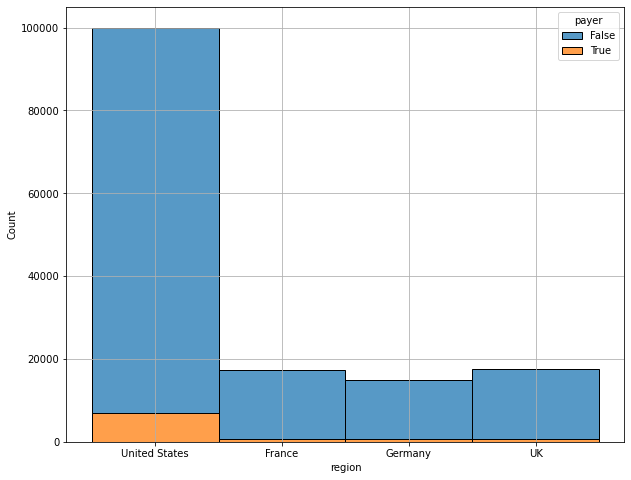

In [40]:
# Посмотрим распределение пользователей по регионам
plt.figure(figsize=(10,8))
sns.histplot(data=profiles[['user_id', 'region', 'payer']], x="region", hue="payer", multiple="stack")
plt.grid();

Из графика видно, что больше всего пользователей было зарегистрированно в United States (около 100 тыс) и количество пользователей из этой страны превышает более чем в 5 раз количество пользователей из других стран.

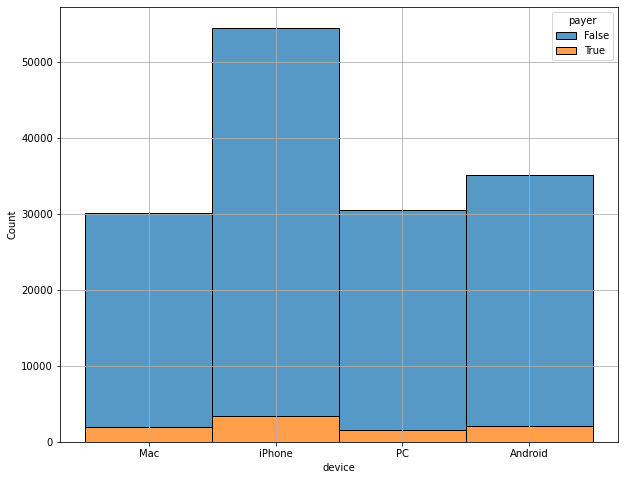

In [41]:
# Посмотрим распределение пользователей по используемым устройствам
plt.figure(figsize=(10,8))
sns.histplot(data=profiles[['user_id', 'device', 'payer']], x="device", hue="payer", multiple="stack")
plt.grid();

Пользователи используют 4 устройства, из них самый распространенный это iPhone. Количество пользователей, которые используют iPhone составляет примерно 55 тыс. Количество пользователей, которые используют другие устройства (Mac, PC, Android) примерно одинаковое и составляет около 30 тыс пользователей, что ниже количества пользователей iPhone примерно на 20тыс

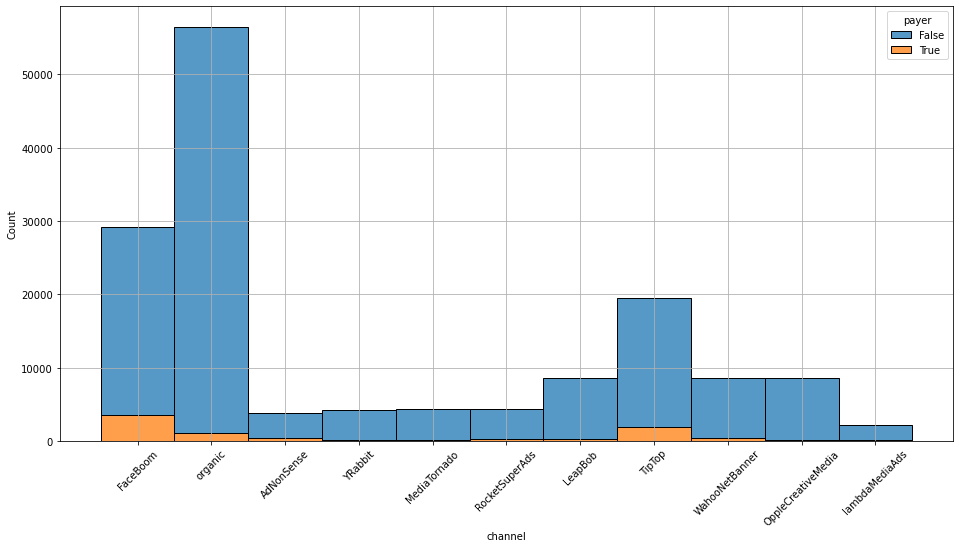

In [42]:
# Посмотрим распределение пользователей по каналам привлечения
plt.figure(figsize=(16,8))
sns.histplot(data=profiles[['user_id', 'channel', 'payer']], x="channel", hue="payer", multiple="stack")
plt.grid()
plt.xticks(rotation=45);

Из графика видно, что больше всего пользователей (около 55 тыс) было привлечено ествественным способом, т.е без рекламы. Следующий канал по популярности это FaceBoom. Через него было привлечено около 30 тыс пользователей. На третьем месте по количеству превлеченных пользователей стоит ресурс TipTop (около 20 тыс). Однако, количество заплативших пользователей , привлеченных через FaceBoom и TipTop значительно больше, чем заплативших пользователей, привлеченных естественным образом (через канал organic).

Посмотрим количество платящих пользователей по регионам, по используемым устройствам и по каналам привлечения. Для этого создадим функцию

In [43]:
# Функция для определения количества платящих и не платящих пользователей в зависимости от категории(регион, устройство)
def profiles_payer(df, category):
    df_payer = df.pivot_table(index='payer', values='user_id', columns=category, aggfunc='count').T
    df_payer = df_payer.reset_index()
    # переименуем клонки
    df_payer.rename(columns={False: "payer_No", True: "payer_Yes"}, inplace=True)
    df_payer['total'] = df_payer['payer_No'] + df_payer['payer_Yes']
    df_payer['ratio_payer'] = df_payer['payer_Yes']/df_payer['total']*100
    return df_payer

In [44]:
# Сводная таблица по регионам
profiles_reg = profiles_payer(profiles, 'region')
profiles_reg.sort_values(by='ratio_payer',ascending=False)

payer,region,payer_No,payer_Yes,total,ratio_payer
3,United States,93100,6902,100002,6.901862
1,Germany,14365,616,14981,4.111875
2,UK,16875,700,17575,3.982930
0,France,16787,663,17450,3.799427


In [45]:
# Сводная таблица по устройствам использования
profiles_dev = profiles_payer(profiles, 'device')
profiles_dev.sort_values(by='ratio_payer',ascending=False)

payer,device,payer_No,payer_Yes,total,ratio_payer
1,Mac,28130,1912,30042,6.364423
3,iPhone,51097,3382,54479,6.207897
0,Android,32982,2050,35032,5.851793
2,PC,28918,1537,30455,5.046790


In [46]:
# Сводная таблица по каналам привлечения
profiles_ch = profiles_payer(profiles, 'channel')
profiles_ch.sort_values(by='ratio_payer',ascending=False)

payer,channel,payer_No,payer_Yes,total,ratio_payer
1,FaceBoom,25587,3557,29144,12.204914
0,AdNonSense,3440,440,3880,11.340206
9,lambdaMediaAds,1924,225,2149,10.469986
6,TipTop,17683,1878,19561,9.600736
5,RocketSuperAds,4096,352,4448,7.913669
7,WahooNetBanner,8100,453,8553,5.296387
8,YRabbit,4147,165,4312,3.826531
3,MediaTornado,4208,156,4364,3.574702
2,LeapBob,8291,262,8553,3.063253
4,OppleCreativeMedia,8372,233,8605,2.707728


### Выводы:
Посетители приходят из 4х стран: США, Германия, Великобритания и Франция. Большенство пользователей из США (100 тыс.). Примерно поравну пользователей из Великобритании и Франции (17,5 тыс.) и чуть меньше пользователей из Германии (15 тыс.). Только 4% пользователей из Великобритании, Франции и Германии заплатили. Процент заплативших пользователей в США выше и составляет практически 7%.

Пользователи используют 4 устройства (Mac, iPhone, Android, PC). Самое распространенное устройство - iPhone (54.5 тыс.). По 30 тыс. пользователей используют Mac и PC, и 35 тыс. используют Android. Процент заплативших пользователей варьируется от 5% (PC) до 6,4% (Mac). Т.е, можно сделать вывод, что здесь нет сильной разницы процента оплативших пользователей в зависимости от устройства использования.

Пользователи привлекаются по 11 каналам. Самое большое количество пользователей (56 тыс.) было привлечено естественным образом, т.е без рекламы (канал organic). Однако, только 2% пользователей из этого канала заплатили (1160 пользователей из 56 тыс. заплатило) - это самый низкий показатель среди всех каналов. Самый высокий процент заплативших пользователей пришло через канал FaceBoom (12% - 3557 пользователей заплатило). Высокий процент заплативших пользователей (около 10%) было привлечено через каналы AdNonSense и IambdaMediaAds. Однако, даже в сумме количество заплативших пользователей из этих каналов меньше, чем количество заплативших пользователей, пришедших естественным образом (665 против 1160 из organic).

# Шаг 4. Маркетинг

Определение:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

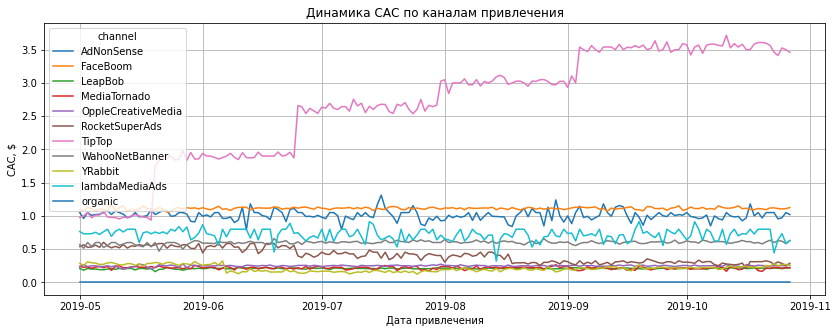

In [47]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(14, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Из графика видно, что траты на привлечение одного посетителя для всех источников кроме одного (TipTop) колеблются возле одного значения (приблизительно от `0,25$` до `1$` на пользователя). Для канала TipTop траты росли ступенчато: в мае расходы были увеличены на `2$`, в июне на `0,5$`, в июле еще на `0,5$` и в сентябре еще раз увеличили траты на `0,5$`. Т.е с мая по ноября траты выросли на `3,5$` на каждого пользователя.

Посмотрим сколько было потрачено на рекламу в целом, на каждый источник и по времени.

В целом, на рекламу с 1 мая 2019 по 10 октября 2019 было потрачено:

In [48]:
int(profiles['acquisition_cost'].sum())

105497

In [49]:
# Построим сводную таблицу трат на рекламу для каждого источника
df_payer_adv = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum').sort_values(by='acquisition_cost',ascending=False)
df_payer_adv = df_payer_adv.reset_index()
df_payer_adv['ratio'] = df_payer_adv['acquisition_cost'] / df_payer_adv['acquisition_cost'].sum()
df_payer_adv

,channel,acquisition_cost,ratio
0,TipTop,54751.30,0.518983
1,FaceBoom,32445.60,0.307549
2,WahooNetBanner,5151.00,0.048826
3,AdNonSense,3911.25,0.037074
4,OppleCreativeMedia,2151.25,0.020392
5,RocketSuperAds,1833.00,0.017375
6,LeapBob,1797.60,0.017039
7,lambdaMediaAds,1557.60,0.014764
8,MediaTornado,954.48,0.009047
9,YRabbit,944.22,0.008950


Более половины всех затрат (практически 52%) было потрачено на рекламу на канале TipTop (54751 $). 31 % затрат было потрачено на рекламу на канале FaceBoom. Траты на другие каналы значительно ниже : менее 5%

Посмотрим как менялись траты на рекламу по времени (по месяцам)

In [50]:
# Построим сводную таблицу трат на рекламу для каждого источника
df_payer_adv_m = profiles.pivot_table(index='channel', values='acquisition_cost',columns='month', aggfunc='sum')
df_payer_adv_m

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,1169.70,538.650,504.00,579.60,581.70,537.600
FaceBoom,3524.40,5501.100,5294.30,6274.40,6114.90,5736.500
LeapBob,140.28,314.580,313.53,369.81,343.98,315.420
MediaTornado,238.56,138.000,138.48,154.56,144.72,140.160
OppleCreativeMedia,169.75,370.000,366.50,439.25,427.75,378.000
RocketSuperAds,577.98,325.715,252.07,253.11,218.40,205.725
TipTop,2981.00,6675.600,8410.20,11202.00,13232.50,12250.000
WahooNetBanner,418.80,921.000,851.40,1040.40,977.40,942.000
YRabbit,299.70,106.200,97.38,124.74,152.79,163.410


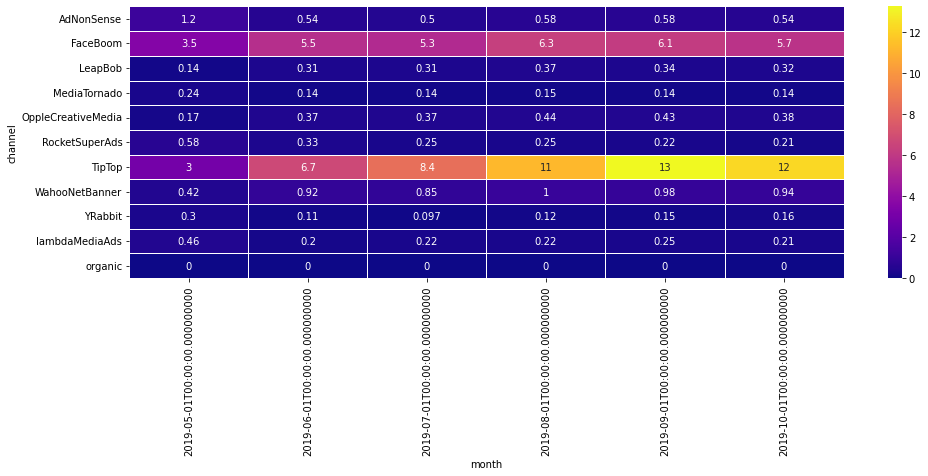

In [51]:
# Построим тепловую мартицу для распределения трат по месяцам ($ тыс в месяц)
plt.figure(figsize = (16,5))
sns.heatmap(df_payer_adv_m/1000, annot=True, linewidths=.5, cmap="plasma");

Из тепловой матрицы хорошо видно, что самые большие траты идут на рекламу в FaceBoom и TipTop. Бюджет на рекламу в этих каналах растет с каждым месяцем ( в последнем месяце видно небольшое снижение затрат, но возможно это связано с тем, что в расчет не вошел весь месяц, а только до 27 октября).

Построим график для остальных каналов (без учета FaceBoom and TipTop)

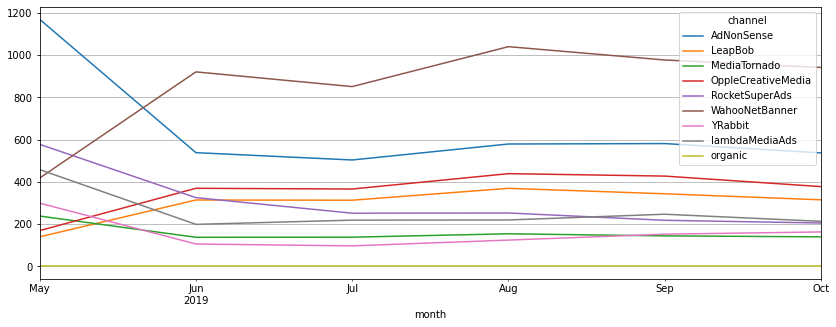

In [52]:
df_payer_adv_m.query('channel != "FaceBoom" and channel !="TipTop"').T.plot(grid=True, figsize=(14, 5));

Затраты на рекламу в трех каналах (LeapBob, OppleCreativeMedia, WahooNetBanner) выросли, а в 5ти - снизились. Самое большое снижение было для канала AdNonSense - c 1170 до 540 $ в месяц. 

Посмотрим сколько в среднем стоило привлечение одного посетителя из каждого источника

In [53]:
# Построим сводную таблицу средних трат на одного покупателья из каждого источника за все время 
df_payer_adv_avg = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
df_payer_adv_avg

,acquisition_cost
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


In [54]:
# Построим сводную таблицу средних трат на одного посетителя из каждого источника по месяцам
df_payer_adv_avg_m = profiles.pivot_table(index='channel', values='acquisition_cost',columns='month', aggfunc='mean')
df_payer_adv_avg_m

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,1.027856,1.012500,0.992126,0.995876,1.004663,0.993715
FaceBoom,1.105868,1.116748,1.113652,1.112088,1.114434,1.114316
LeapBob,0.201842,0.211696,0.209859,0.210478,0.210385,0.212261
MediaTornado,0.226768,0.218354,0.215365,0.224325,0.210962,0.211722
OppleCreativeMedia,0.243544,0.249831,0.251544,0.250142,0.250586,0.250829
RocketSuperAds,0.549411,0.498798,0.417334,0.354000,0.302493,0.293056
TipTop,1.357468,2.077684,2.650552,3.011290,3.480405,3.543535
WahooNetBanner,0.577655,0.598441,0.607709,0.605941,0.601477,0.609314
YRabbit,0.281144,0.182788,0.161493,0.191908,0.213992,0.234112


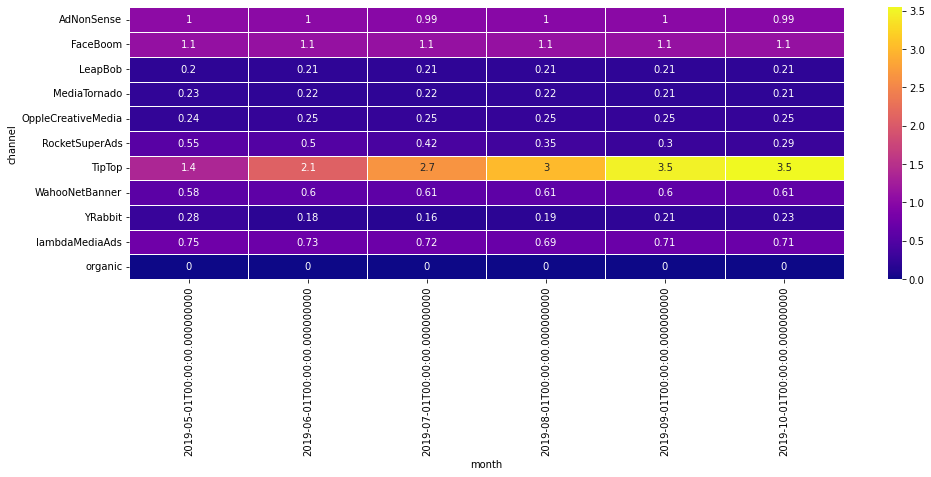

In [55]:
# Построим тепловую мартицу для распределения затрат на првлечение одного посетителя по месяцам 
plt.figure(figsize = (16,5))
sns.heatmap(df_payer_adv_avg_m, annot=True, linewidths=.5, cmap="plasma");

Видно, что стоимость привлечения одного посетителя растет только для одного канала (TipTop). Для остальных каналов стоимость привлечения одного посетителя меняется не значительно. Ранее мы видили, что бюждет на рекламу значительно растет для двух каналов - FaceBoom and TipTop. Т.е, получается, что количество посетителей от канала FaceBoom растет, при неизменной стоимости привлечения одного посетителя.

Посчитаем сколько в среднем стоило привлечение одного покупателя из каждого источника

In [56]:
# Построим сводную таблицу распределения платящих посетителей по каналам привлечения и месяцам
df_payer_id = profiles.query('payer==True').pivot_table(index='channel', values='user_id',columns=('month'), aggfunc='count')
df_payer_id

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,110,64,49,68,77,72
FaceBoom,375,588,589,670,692,643
LeapBob,20,41,49,59,50,43
MediaTornado,37,23,23,22,24,27
OppleCreativeMedia,15,41,39,43,58,37
RocketSuperAds,98,46,50,52,57,49
TipTop,204,336,298,367,368,305
WahooNetBanner,45,85,71,94,81,77
YRabbit,34,25,27,28,30,21


In [57]:
# Определим стоимость првлечения покупателя как результат деления суммы затрат на рекламу на кол-во покупателей (по месяцам)
df_cost_payer = df_payer_adv_m/df_payer_id

In [58]:
df_cost_payer

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,10.633636,8.416406,10.285714,8.523529,7.554545,7.466667
FaceBoom,9.398400,9.355612,8.988625,9.364776,8.836561,8.921462
LeapBob,7.014000,7.672683,6.398571,6.267966,6.879600,7.335349
MediaTornado,6.447568,6.000000,6.020870,7.025455,6.030000,5.191111
OppleCreativeMedia,11.316667,9.024390,9.397436,10.215116,7.375000,10.216216
RocketSuperAds,5.897755,7.080761,5.041400,4.867500,3.831579,4.198469
TipTop,14.612745,19.867857,28.222148,30.523161,35.957880,40.163934
WahooNetBanner,9.306667,10.835294,11.991549,11.068085,12.066667,12.233766
YRabbit,8.814706,4.248000,3.606667,4.455000,5.093000,7.781429


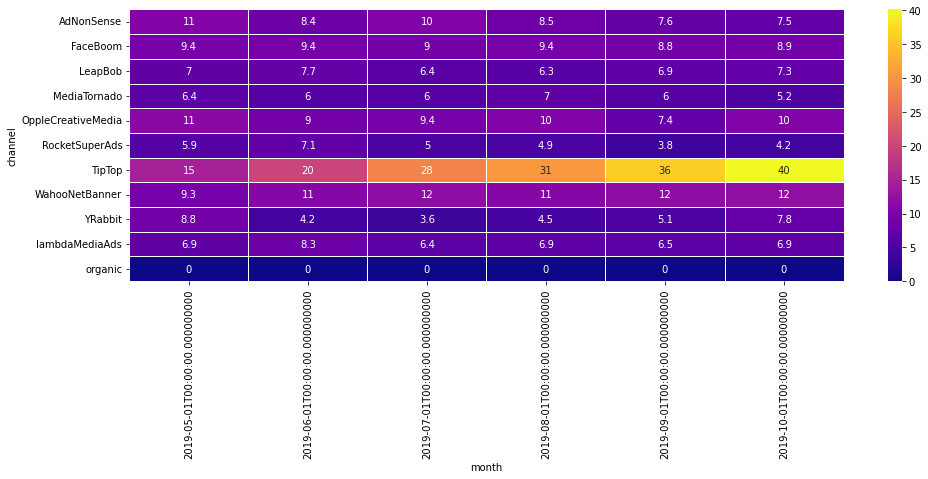

In [59]:
# Построим тепловую мартицу для стоимости привлечения покупателя по каналам
plt.figure(figsize = (16,5))
sns.heatmap(df_cost_payer, annot=True, linewidths=.5, cmap="plasma");

In [60]:
# Построим как менялись траты по месяцам
profiles.pivot_table(index='month', values='acquisition_cost', aggfunc='sum')

,acquisition_cost
month,
2019-05-01,9978.570
2019-06-01,15090.045
2019-07-01,16447.060
2019-08-01,20657.870
2019-09-01,22441.340
2019-10-01,20882.415


### Выводы:
Затраты на рекламу с мая по октябрь выросли более чем в два раза (с 10 тыс. $ до 21 тыс $). Самые большие траты идут на два канала - FaceBoom and TipTop. Однако, средняя стоимость привлечения одного посетителя для канала FaceBoom не меняется со временем, а средняя стоимость привлечения одного покупателя для этого же канала падает. Т.е для этого канала реклама работает хорошо. Для канала TipTop средняя стоимость привлечения одного посетителя только растет: на конец анализируемого периода стоимость привлечения одного посетителя для канала TipTop больше чем в 3 раза, чем стоимость для канала FaceBoom (3.5 $ против 1.1 $). А средняя стоимость привлечения одного покупателя через канал TipTop составляет 40 $, что более в 4 раза превышает среднюю стоимость привлечения одного покупателя через канал FaceBoom.

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Изучим:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Установим момент и горизонт анализа данных:

In [61]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа - 1 ноября 2019 года
horizon_days = 14  # горизонт анализа 

### Проанализируем общую окупаемость рекламы

Посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI

In [62]:
# Не будем учитывать канал organic для анализа окупаемости рекламы
# получаем профили пользователей без учета канала organic
profiles = get_profiles(visits.query('channel != "organic"'), orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel   device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom      Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom   iPhone  United States   
2  22593348 2019-08-22 21:35:48  AdNonSense       PC        Germany   
3  31989216 2019-10-02 00:07:44     YRabbit   iPhone  United States   
4  46006712 2019-06-30 03:46:29  AdNonSense  Android         France   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.076596  
1  2019-07-09 2019-07-01  False          1.092857  
2  2019-08-22 2019-08-01  False          0.988235  
3  2019-10-02 2019-10-01  False          0.214286  
4  2019-06-30 2019-06-01   True          1.008000  


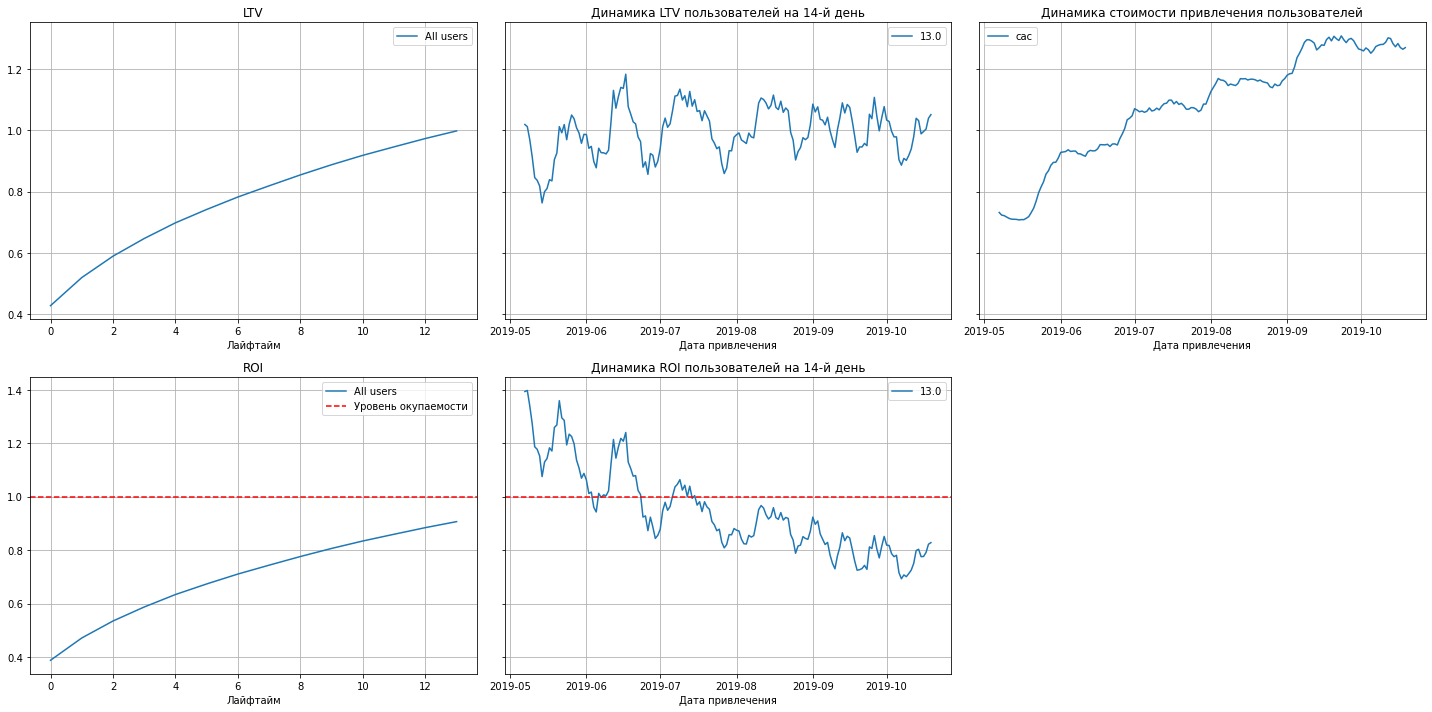

In [63]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать вывод:
 Реклама не окупается. ROI в конце второй недели только приближается к 100% и достигает примерно 90%. По динамике изменения ROI видно, что реклама окупалась до июля, а после ROI снижается и реклама не окупается начиная с середины июля.
 Стоимость привлечения пользователей (CAC) растёт, причем имеется значительный скачек от мая до июня.
 LTV пользователей на 14й день в первой половине мая снижалась, а начиная со второй половины и до середины июня росла, однако после было резкое снижение и после идут скачки роста и снижения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

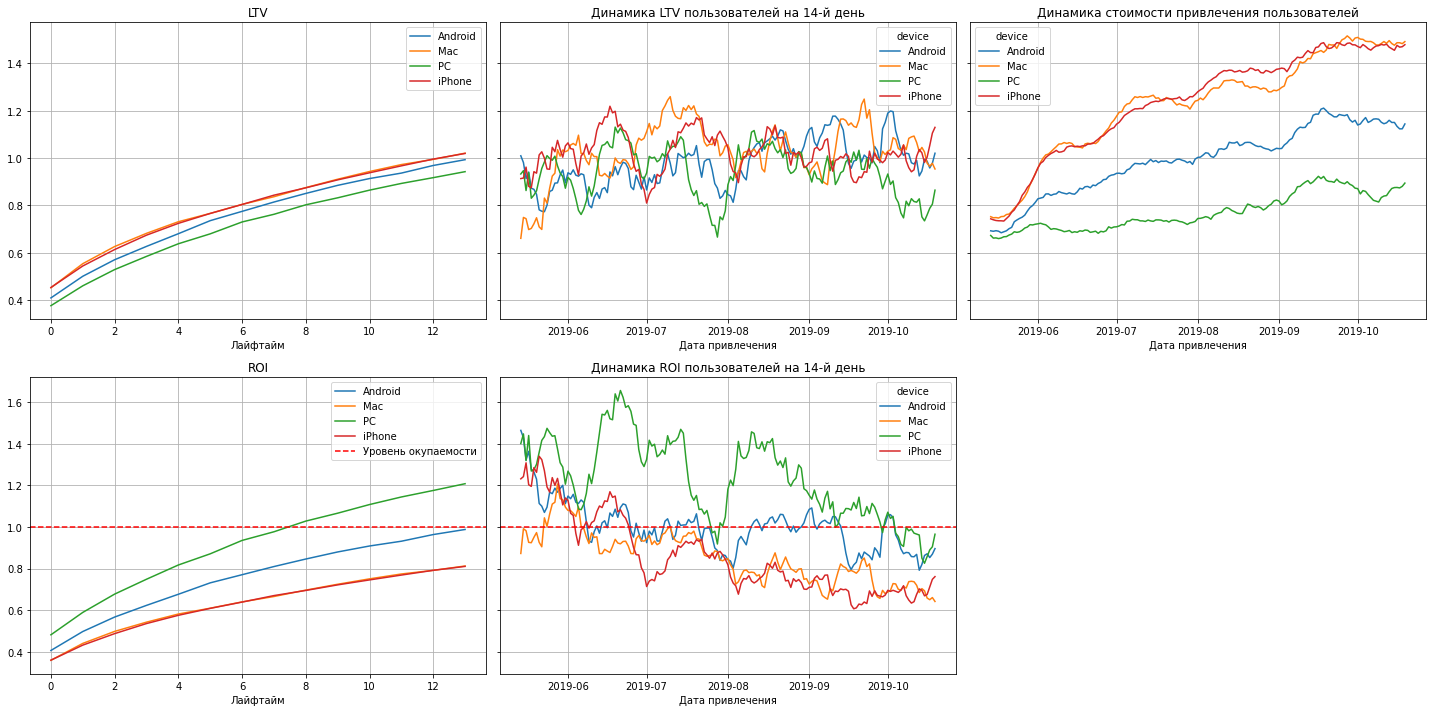

In [64]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графику ROI видно, что реклама окупается к концу первой недели только для пользователей с устройством PC. Для пользователей с устройством Android ROI приближается к порогу окупаемости только к концу второй недели. Для пользователей с устройствами Mac и iPhone реклама не окупается - к концу второй недели ROI достигает только 80%.

Также видно, что стоимости привлечения пользователей для пользователей Mac и iPhone растет быстрее чем стоимость привлечения пользователей с другими устройствами.

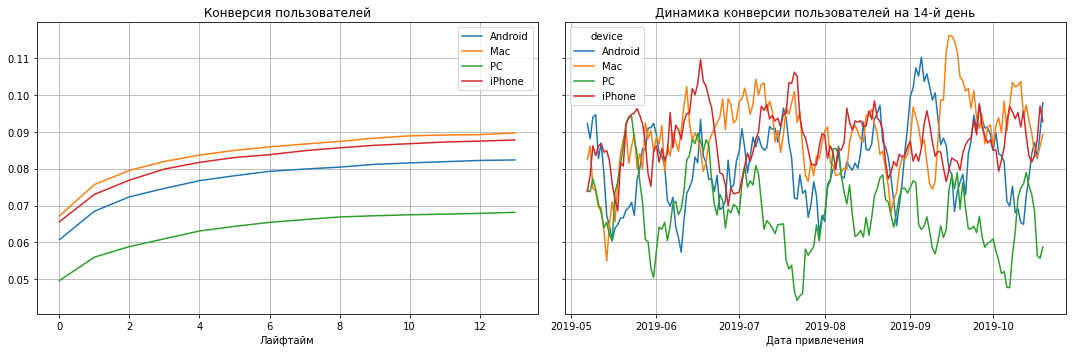

In [65]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

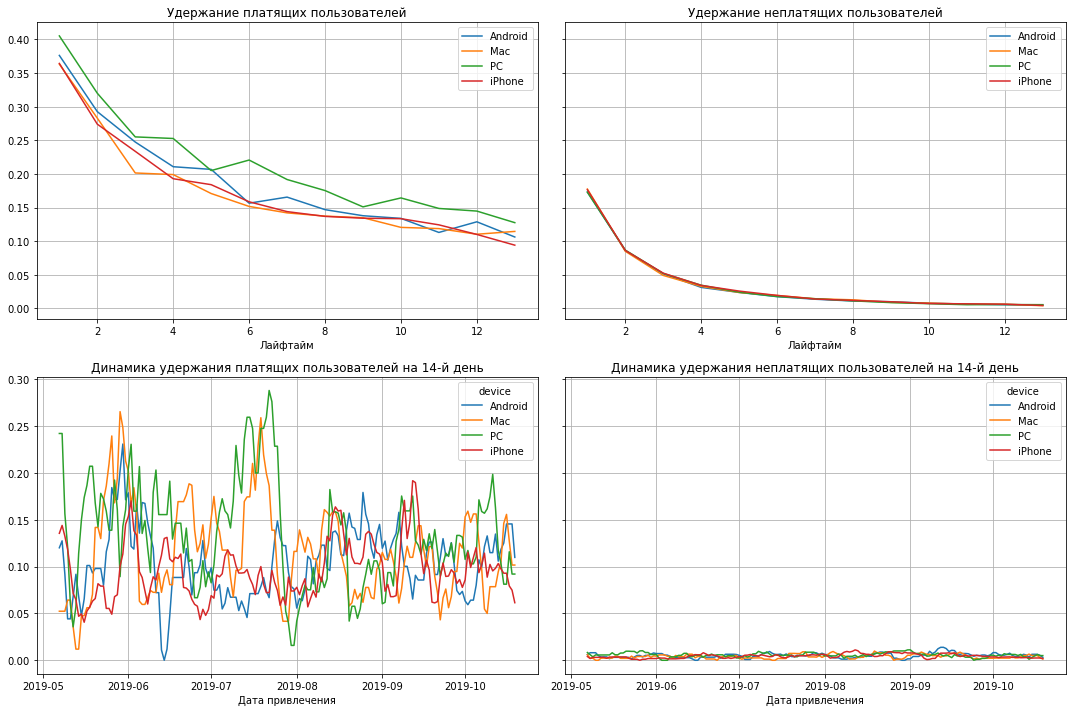

In [66]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Проанализируем окупаемость рекламы с разбивкой по странам

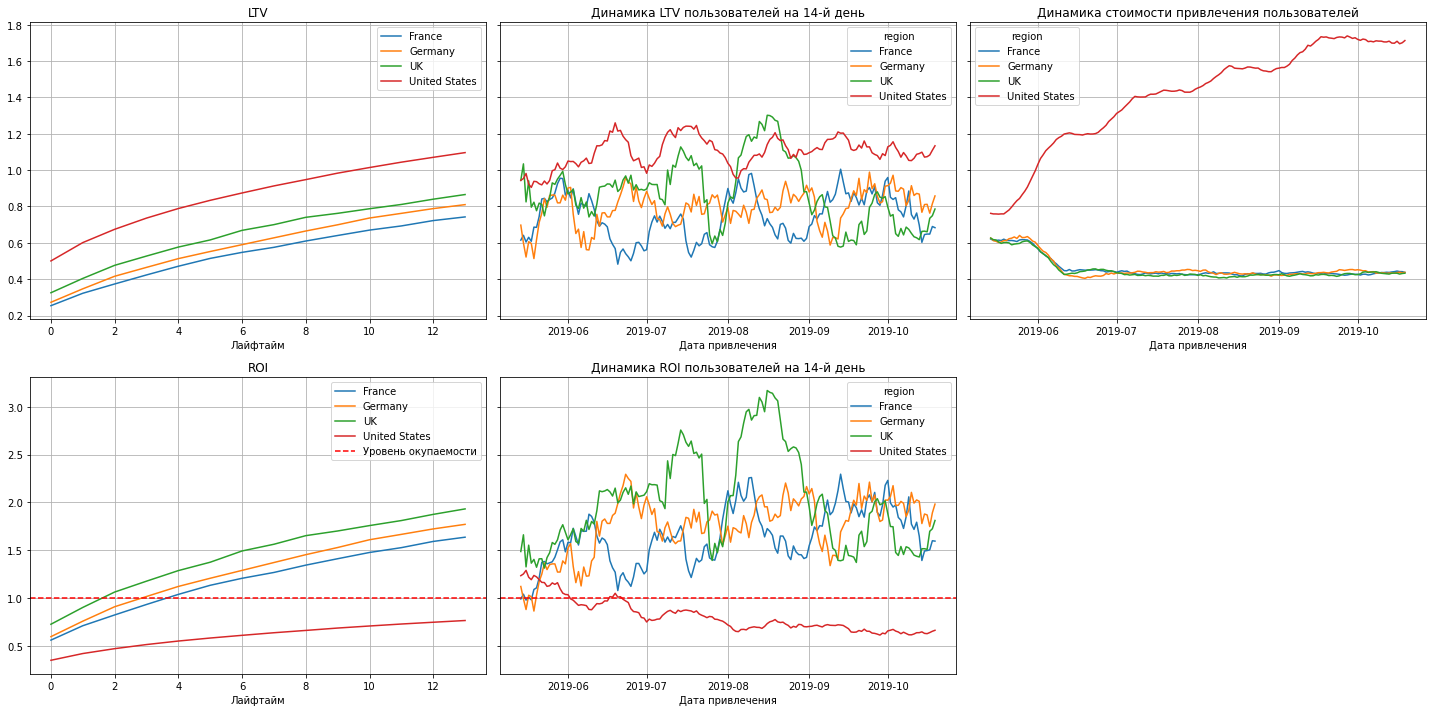

In [67]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама на пользователей из США не окупается и ROI составляет примерно 80% на 14 день. Для всех остальных регионов реклама окупается достаточно быстро - к концу первой недели. Траты на рекламу для пользователей из США значительно превышают траты для других регионов. Однако и LTV для пользователей из США самый высокий с первого дня и до конца 2й недели. Однако реклама не окупаетс начиная середины июня

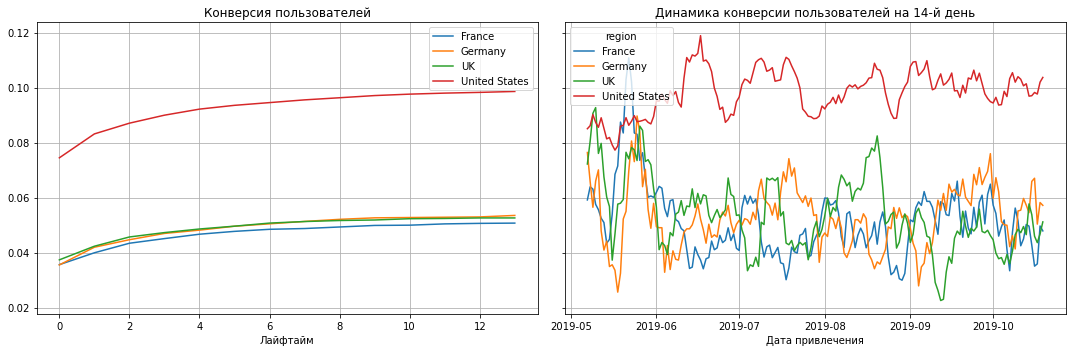

In [68]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

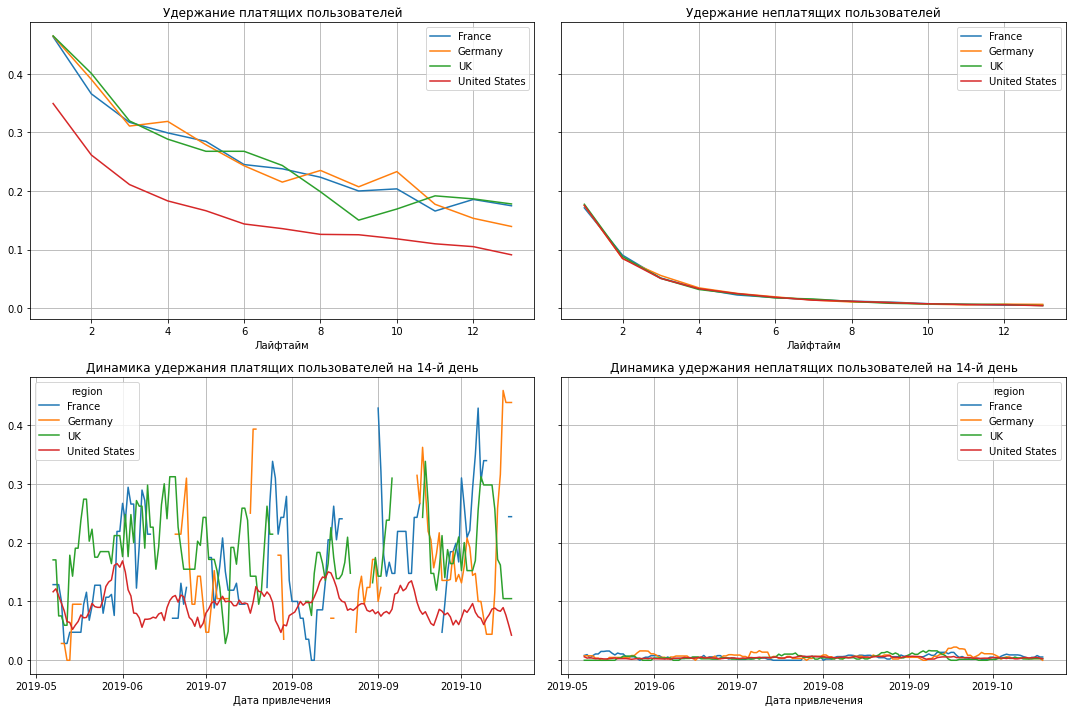

In [69]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

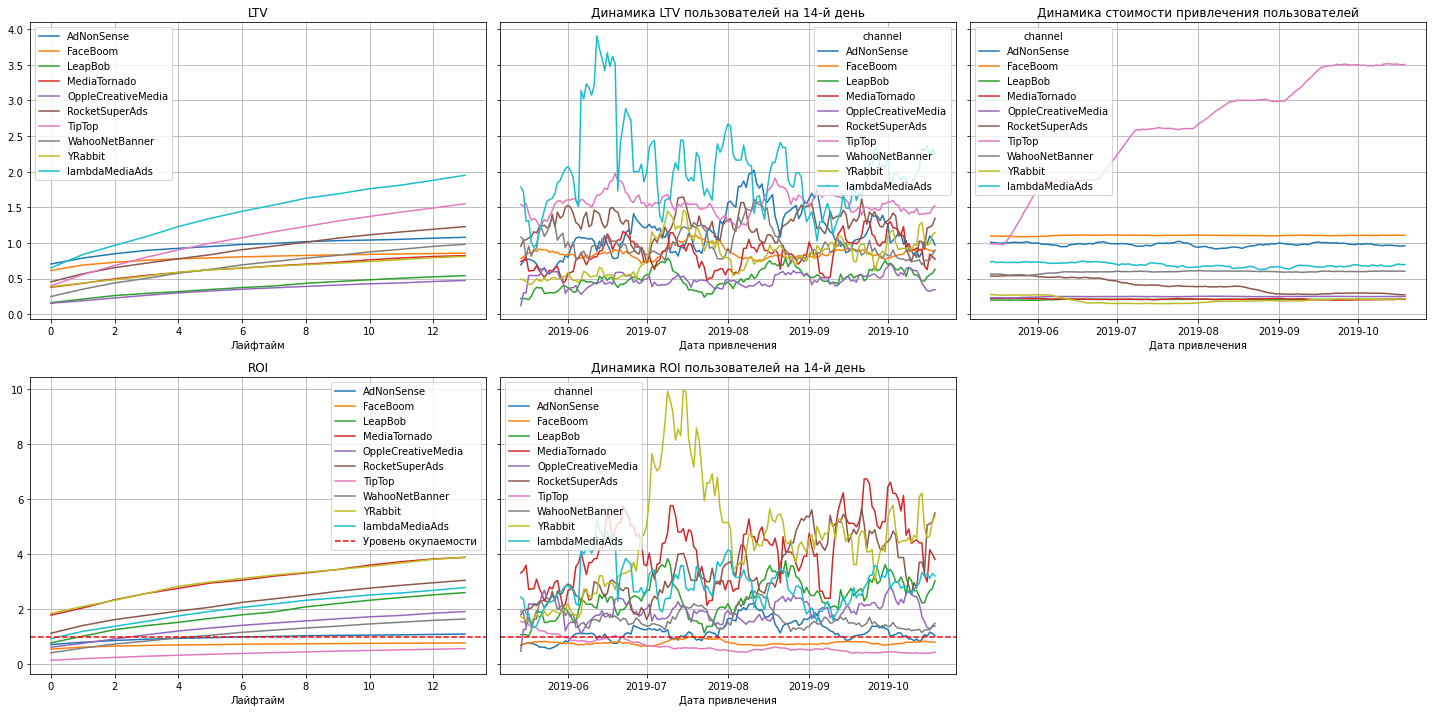

In [70]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Посмотрим более детально на график ROI

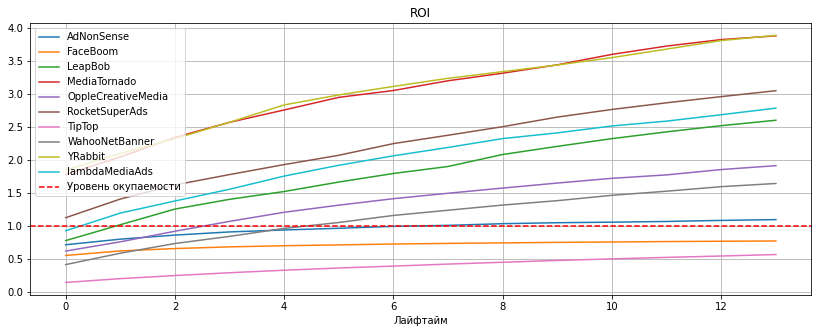

In [71]:
roi = roi_grouped.drop(columns=['cohort_size', 'cac'])
roi.T.plot(grid=True, figsize=(14, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('ROI');

ROI для пользователей, привлеченных через каналы FaceBoom и TipTop растет медленно и не достигает 100% к концу второй недели. По графику динамики ROI видно, что реклама стабильно не окупается на каналах FaceBoom и TipTop начиная с июня. Затраты на рекламу очень большие и очень сильно растут для канала TipTop (для канала FaceBoom затраты на рекламу не меняются с мая по ноябрь). 

Можно сделать вывод, что пользователи, привлеченные через канал TipTop совершают много покупок (на втором месте после канала lambdaMediaAds на конец второй недели), однако, затраты на рекламу превышают выручку. 

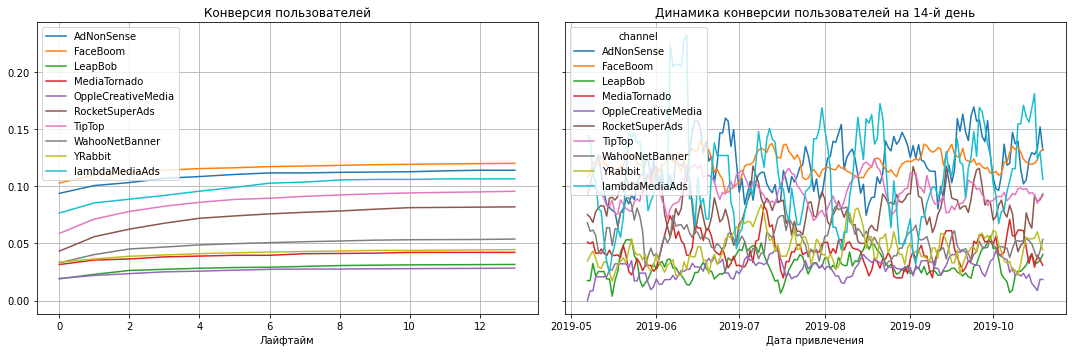

In [72]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

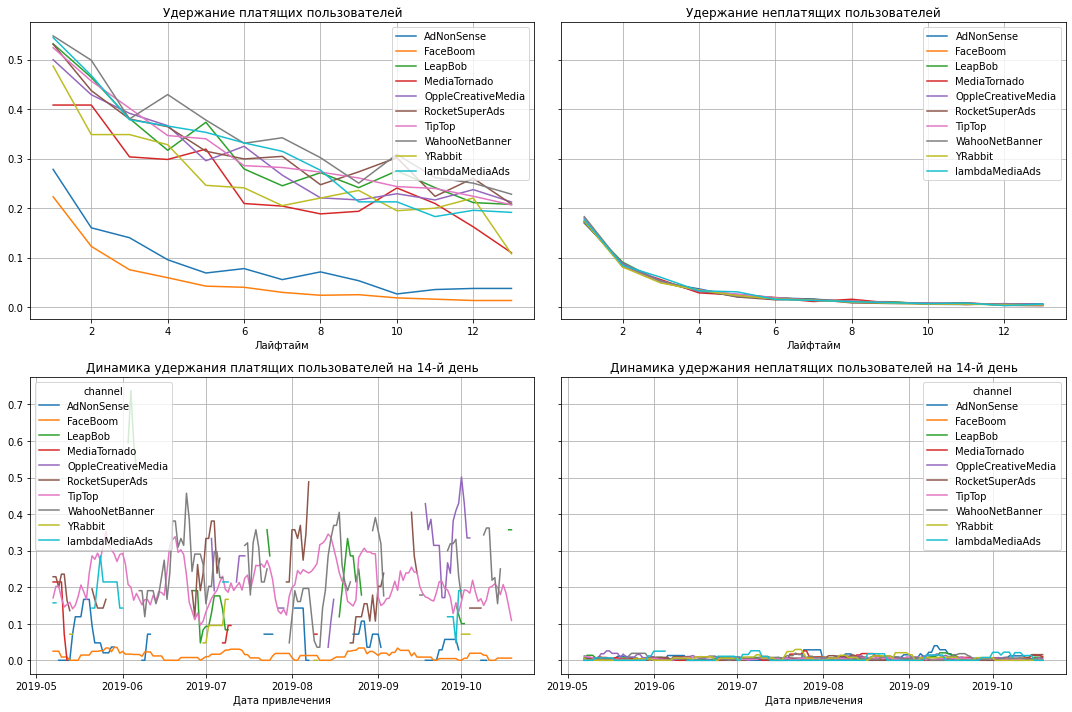

In [73]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графику конверсии видно, что пользователи пришедшие через FaceBoom быстро начинают совершать покупки, однако, по графику удержания платящих пользователей видно, что эти пользователи очень быстро прекращают совершать покупки - быстрее чем пользователи, пришедшие естественным путем

# Шаг 6. Выводы


Похоже, что убытки связаны с рекламными кампаниями на каналах TipTop и FaceBoom. Реклама на этих ресурсах стоит очень дорого, интерес пользователей, пришедших через канал FaceBoom быстро падает и убытки на рекламу не успевают окупиться. 

Скорее всего развлекательное приложение Procrastinate Pro+ не может конкурировать с развлекательным приложениями FaceBoom, и пользователи быстро теряют интерес, а стоимость рекламы здесь высокая. 

Пользователи, пришедшие с канала TipTop совершают много покупок, не быстро теряют интерес, однако стоимость рекламы на этом канале очень большая - и затраты не окупаются.

Рекомендация для отдела маркетинга: размещать рекламу не на развлекательных каналах, которые могут конкурировать с приложением  Procrastinate Pro+. Однако, каналы FaceBoom и TipTop смогли привлечь покупателей, но реклама очень дорогая. Желательно сохранить рекламу на этих каналах, но изменить тип оплаты рекламы - поменять на более дешевый вариант - например на Cost Per Mille.

Для канала FaceBoom необходимо проверить, почему пользователи быстро теряют интерес. Канал показывает себя очень хорошо по конвертации и по величине покупок в первый день, однако, по какой то причине, пользователи не возвращаются в последующие дни в приложение - необходимо изучить причину и устранить ее. 